# Creating the Huacos Data Set from Google Images

The next few lines follow the instructions from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb and collect images from Google for the categories of Huacos that we are interested in. The Google search terms used were:

* mochica ceramics
* chimu ceramics
* chavin ceramics
* nazca ceramics
* paracas ceramics
* inca ceramics
* tiahuanaco ceramics

**NB** A quick visual inspection of the images shows a couple of problems: first that not all of the images returned are actual photographs (despite the fact that we asked Google to only search for photographs) and two that several of the images appeared in different searches, i.e. a the same 'huaco' appeared to be labeled as both Inca and Nazca. Some manual cleaning of the database will be needed to deal with this problem as it could affect the accuracy of the results. 

In [1]:
from fastai.vision import *

## Create Directories for the data

Note that the `csv` files have to be inside the `data\huacos` directory

In [2]:
folder = 'mochica'
file = 'urls_mochica.csv'

In [3]:
folder = 'chimu'
file = 'urls_chimu.csv'

In [4]:
folder = 'chavin'
file = 'urls_chavin.csv'

In [5]:
folder = 'nazca'
file = 'urls_nazca.csv'

In [6]:
folder = 'paracas'
file = 'urls_paracas.csv'

In [7]:
folder = 'inca'
file = 'urls_inca.csv'

In [8]:
folder = 'tiahuanaco'
file = 'urls_tiahuanaco.csv'

The following lines create the data folders, note that the line below has to be run multiple times. First run one of the lines above for each category and then run the lines below.

In [9]:
path = Path('data/huacos')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [10]:
path.ls()

[PosixPath('data/huacos/tiahuanaco')]

In [11]:
classes = ['inca', 'paracas', 'nazca', 'chimu', 'mochina', 'chavin', 'tiahuanaco']

## Donwload the images
The next line of code has to be run once for each category. Set up the values using the cells in earlier parts of this notebook

In [12]:
folder = 'mochica'
file = 'urls_mochica.csv'
dest = path/folder

print(file)
print(dest)

urls_mochica.csv
data/huacos/mochica


In [14]:
download_images(path/file, dest, max_pics=400)

In [15]:
folder = 'chimu'
file = 'urls_chimu.csv'
dest = path/folder
print(dest)

data/huacos/chimu


In [16]:
download_images(path/file, dest, max_pics=400)

In [17]:
folder = 'chavin'
file = 'urls_chavin.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/chavin


In [18]:
folder = 'inca'
file = 'urls_inca.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/inca


Error https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSOcFSUsgCZDf0uDnM7_arY-eKkX43rGm92XPmOPQfKatk8h4dj HTTPSConnectionPool(host='encrypted-tbn0.gstatic.com', port=443): Read timed out. (read timeout=4)


In [19]:
folder = 'paracas'
file = 'urls_chimu.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/paracas


In [20]:
folder = 'nazca'
file = 'urls_nazca.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/nazca


In [21]:
folder = 'tiahuanaco'
file = 'urls_tiahuanaco.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/tiahuanaco


Error https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR0L5rk8GwOaxwwtZGVhusI90P4n9kO5pg71geTzOuvVbmTMmah HTTPSConnectionPool(host='encrypted-tbn0.gstatic.com', port=443): Max retries exceeded with url: /images?q=tbn%3AANd9GcR0L5rk8GwOaxwwtZGVhusI90P4n9kO5pg71geTzOuvVbmTMmah (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fa3e0168c50>: Failed to establish a new connection: [Errno 101] Network is unreachable',))
Error https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRwgjxPNjshi2RYCnBcJRGtBMgK6olzrfJA7jkYcveO-O5hb40f HTTPSConnectionPool(host='encrypted-tbn0.gstatic.com', port=443): Max retries exceeded with url: /images?q=tbn%3AANd9GcRwgjxPNjshi2RYCnBcJRGtBMgK6olzrfJA7jkYcveO-O5hb40f (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fa3e01684a8>: Failed to establish a new connection: [Errno 101] Network is unreachable',))


## Look at the Data

In [22]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [23]:
data.classes

['chavin', 'chimu', 'inca', 'mochica', 'nazca', 'paracas', 'tiahuanaco']

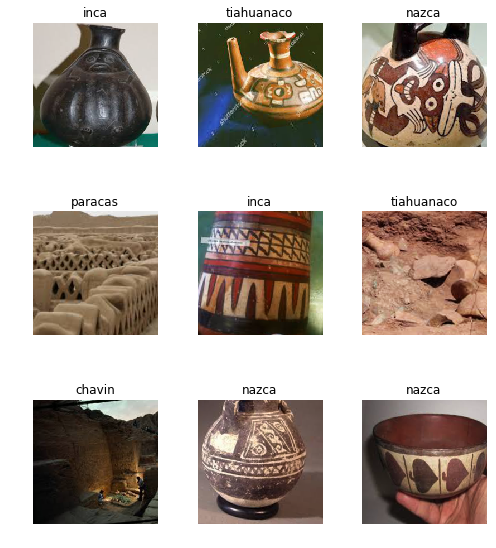

In [24]:
data.show_batch(rows=3, figsize=(7,8))

Some statistics about the data set. Show the classes, the number of classes lenght of the training and validation sets

In [25]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chavin', 'chimu', 'inca', 'mochica', 'nazca', 'paracas', 'tiahuanaco'],
 7,
 2238,
 559)

## First pass at training a Model

Let's train a model. We will use the 'raw' data that we donwloaded. We don't expect very good results because we know that the dataset has some problems that we have already alluded to. We also noticed several items that were not picture. These will affect the results, but we need to do this so that we can clean up the data set later on.

### Train the Model

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.066720,1.459816,0.533095,00:05
1,1.727337,1.364873,0.527728,00:05
2,1.503644,1.267578,0.524150,00:05
3,1.348689,1.265127,0.504472,00:05


The results are not very good. Let's see if we can work on this and improve the results

In [28]:
learn.save('stage-1')

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


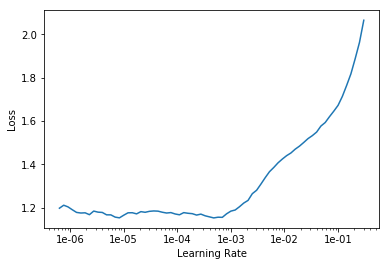

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.202896,1.244475,0.511628,00:05
1,1.040446,1.228632,0.533095,00:05


In [33]:
learn.save('stage-2')

In [34]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2238 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mochica,mochica,mochica,mochica,mochica
Path: data/huacos;

Valid: LabelList (559 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
inca,chavin,paracas,nazca,inca
Path: data/huacos;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

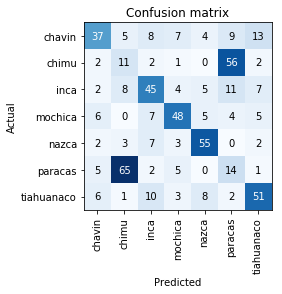

In [36]:
interp.plot_confusion_matrix()

The confusion matrix above does confirm my initial statement that the model was not doing very well. Let's try to clean up the model and remove images that should be there to see if we can improve things

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## Cleaning up the data

As I mentioned earlier, the data that was collected contains images that should not be in the dataset or that should not be in a particular dataset. These 'rogue' images will impact the accuracy and performance of the model. So we are going to clean the data set using the ImageCleaner widget from fastai.widgets . With this widget we can prune our top losses, removing photos that don't belong

In [40]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner. In order to clean the entire set of images, we need to create a new dataset without the split.

In [37]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Create a new learner to use our new databunch with all of the images

In [38]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [41]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Now we run the image cleaner.

In [42]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

Since we already cleaned up the data from `top_losses` we run a different set of commands to create `db` and the new data bunch. Otherwise all results will be overwritten by the new run of `ImageCleaner`

In [43]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

Create a new learner

In [44]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [45]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [46]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [47]:
# Recreate the databunch
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [48]:
#New learner
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [49]:
learn.save('state-3')

In [53]:
learn.unfreeze()

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


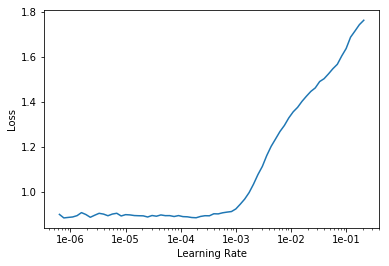

In [55]:
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.911753,1.199805,0.509839,00:05
1,0.843925,1.197403,0.502683,00:05
2,0.726290,1.192040,0.511628,00:05
3,0.625011,1.174869,0.515206,00:05


In [57]:
interp = ClassificationInterpretation.from_learner(learn)

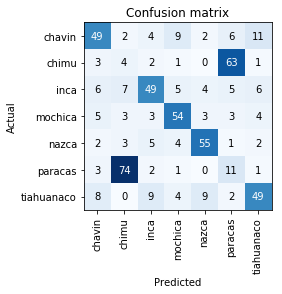

In [58]:
interp.plot_confusion_matrix()